In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Colab Notebooks/explore/ai/11_tensorflow")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


本篇文章我们继续通过一些小例子来让大家进一步熟悉tensorflow框架。

In [2]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict

%matplotlib inline
np.random.seed(1)
tf.compat.v1.disable_eager_execution() # need to disable eager in TF2.x

### 线性函数

下面我们用tensorflow来实现人工智能领域中著名的线性函数: $Y = WX + b$。学习过我教程中前面文章的同学已经对这个函数特别熟悉了。在本例中，我们设W的维度是(4,3)，X的维度是(3,1)以及b的是(4,1)。它们里面填充的都是随机数。

In [3]:
def linear_function():    
    X = tf.constant(np.random.randn(3, 1), name = "X") # 定义一个维度是(3, 1)的常量，randn函数会生成随机数
    W = tf.constant(np.random.randn(4, 3), name = "W")
    b = tf.constant(np.random.randn(4, 1), name = "b")
    Y = tf.add(tf.matmul(W, X), b) # tf.matmul函数会执行矩阵运算
    
    # 创建session，然后用run来执行上面定义的操作
    sess = tf.compat.v1.Session()
    result = sess.run(Y)
    sess.close()

    return result

In [4]:
print( "result = " + str(linear_function()))

result = [[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]]


### sigmoid函数
上面我们用tensorflow实现了深度学习中著名的线性函数，下面我们再来实现sigmoid这个著名的非线性函数。其实，tensorflow框架已经帮我们实现了这些函数了，我们只需要学会使用它们就可以了。下面我给大家展示一下如何用placeholder来使用tensorflow中的sigmoid函数。

In [5]:
def sigmoid(z):
    
    x = tf.compat.v1.placeholder(tf.float32, name="x") # 定义一个类型为float32的占位符
    sigmoid = tf.sigmoid(x) # 调用tensorflow的sigmoid函数，并且将占位符作为参数传递进去
    with tf.compat.v1.Session() as sess: # 创建一个session
        # 用run来执行上面定义的sigmoid操作。
        # 执行时将外面传入的z填充到占位符x中，也就相当于把z作为参数传入了tensorflow的sigmoid函数中了。
        result = sess.run(sigmoid, feed_dict = {x: z}) 
    
    return result

In [6]:
print ("sigmoid(0) = " + str(sigmoid(0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

sigmoid(0) = 0.5
sigmoid(12) = 0.9999939



细心的同学可能发现有两种方法可以创建tensorflow的session: 

**方法 1:**
```python
sess = tf.compat.v1.Session()
result = sess.run(..., feed_dict = {...})
sess.close() 
```
**方法 2:**
```python
with tf.compat.v1.Session() as sess: 
    result = sess.run(..., feed_dict = {...})
```

两种方法都可以使用，具体看个人的喜好。

### Cost函数

cost函数也是人工智能领域的一个重要部分。像sigmoid一样，tensorflow也已经帮我们定义好了各种著名的cost函数。在前面的教程中，我们需要写不少python代码来实现下面的cost函数，而如果使用tensorflow框架，只需要一行代码就可以了: 
$$ J = - \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log a^{ [2] (i)} + (1-y^{(i)})\log (1-a^{ [2] (i)} )\large )\small\tag{2}$$

我们可以用下面的tensorflow函数来一次性实现sigmoid和上面的cost函数，上面的cost函数也叫做cross_entropy函数: 
- `tf.nn.sigmoid_cross_entropy_with_logits(logits = ...,  labels = ...)`

logits参数就是我们最后一层神经元输出的z，labels就是我们的真实标签y。上面的tensorflow函数同时实现了sigmoid和cost函数，所以等于一次性实现了下面的函数：

$$- \frac{1}{m}  \sum_{i = 1}^m  \large ( \small y^{(i)} \log \sigma(z^{[2](i)}) + (1-y^{(i)})\log (1-\sigma(z^{[2](i)})\large )\small\tag{2}$$



In [7]:
def cost(z_in, y_in):    
    
    z = tf.compat.v1.placeholder(tf.float32, name="z") # 创建占位符
    y = tf.compat.v1.placeholder(tf.float32, name="y")
    
    # 使用sigmoid_cross_entropy_with_logits来构建cost操作。
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=z, labels=y)
    
    # 创建session
    sess = tf.compat.v1.Session()
    
    # 将传入的z_in和y_in填充到占位符中，然后执行cost操作
    cost = sess.run(cost, feed_dict={z: z_in, y: y_in})

    sess.close()
    
    return cost

In [8]:
logits = np.array([0.2, 0.4, 0.7, 0.9])
cost = cost(logits, np.array([0, 0, 1, 1]))
print ("cost = " + str(cost))

cost = [0.79813886 0.91301525 0.40318605 0.34115386]


### One Hot编码

再给大家介绍一个tensorflow中很常用的功能——One Hot编码。在人工智能的编程中，我们经常会遇到多分类问题，我们前面学习的softmax就是用来解决多分类问题的。在多分类编程中，我们的y向量要包含0到C-1的数字，里面的C表示类别的数量。例如，假设C是4，那么我们就需要将下图中左边的向量转换成右边的向量。

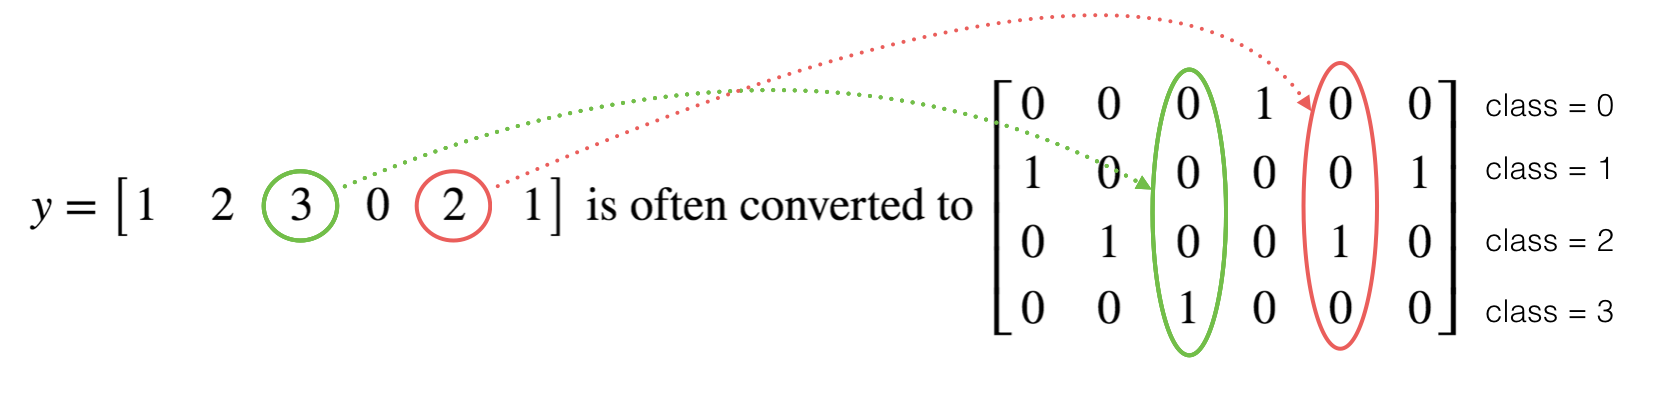
右边的向量就叫做one hot向量，因为向量中只有一个元素是1，其它的都是0。例如，最后一个元素是1就表示类型3。在之前我们实现纯python编程时，如果要实现上面的转换，我们需要写好几行代码，改用tensorflow框架的话，只需要一行代码: 

- tf.one_hot(indices, depth, axis) 

In [9]:
def one_hot_matrix(labels, C_in):
    """
    labels就是真实标签y向量；
    C_in就是类别的数量
    """
  
    # 创建一个名为C的tensorflow常量，把它的值设为C_in
    C = tf.constant(C_in, name='C')
    
    # 使用one_hot函数构建转换操作，将这个操作命名为one_hot_matrix。
    one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)
    
    sess = tf.compat.v1.Session()
    
    # 执行one_hot_matrix操作
    one_hot = sess.run(one_hot_matrix)
  
    sess.close()
    
    return one_hot

In [10]:
labels = np.array([1,2,3,0,2,1])
one_hot = one_hot_matrix(labels, C_in=4)
print ("one_hot = " + str(one_hot))

one_hot = [[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0.]]


### 初始化0和1

最后再介绍两个常用的tensorflow函数，tf.ones()和tf.zeros()。我们将维度信息传入到这两个函数中，它们就会返回填充好1或0的数组。

In [11]:
def ones(shape):
    
    # 将维度信息传入tf.ones中
    ones = tf.ones(shape)
    
    sess = tf.compat.v1.Session()
    
    # 执行ones操作
    ones = sess.run(ones)
    
    sess.close()
    
    return ones

In [12]:
print ("ones = " + str(ones([3,5])))

ones = [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


好，tensorflow的基本特性就介绍到这里了，大家应该对tensorflow不再陌生了，下篇文章教大家用tensorflow来构建一个完整的人工智能程序！